In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("D:\data prep\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_bureau_balance.csv")
df

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [3]:
number_missing = df.isnull().sum()
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'column_name': df.columns,
                                 'number_missing' : number_missing,
                                 'percent_missing': percent_missing})
missing_value_df

,column_name,number_missing,percent_missing
SK_ID_BUREAU,SK_ID_BUREAU,0,0.0
MONTHS_BALANCE,MONTHS_BALANCE,0,0.0
STATUS,STATUS,0,0.0


<Axes: ylabel='SK_ID_BUREAU'>

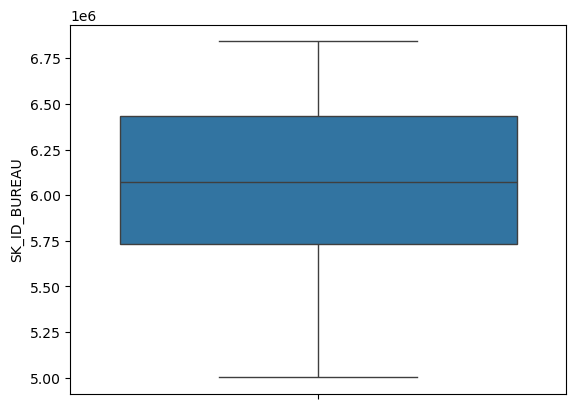

In [4]:
sns.boxplot(df['SK_ID_BUREAU'])

<Axes: ylabel='MONTHS_BALANCE'>

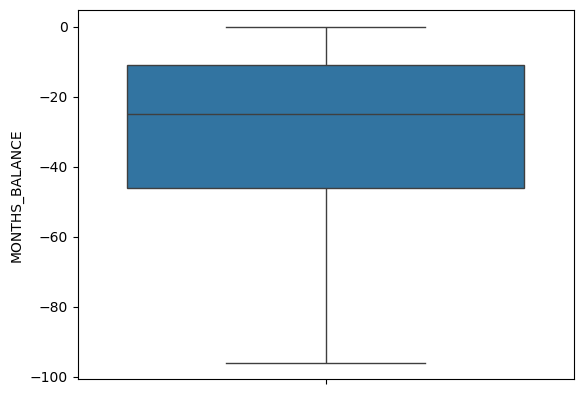

In [5]:
sns.boxplot(df['MONTHS_BALANCE'])

<Axes: ylabel='STATUS'>

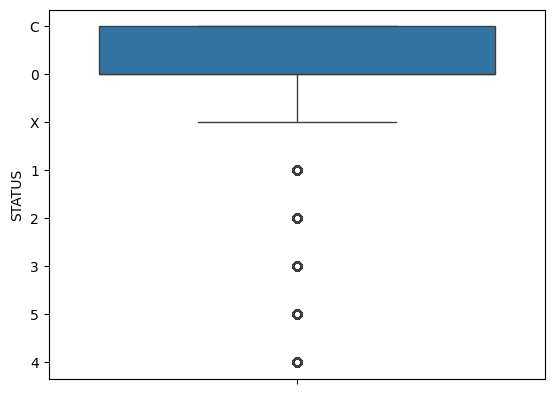

In [6]:
sns.boxplot(df['STATUS'])

In [7]:
numerical_data = df._get_numeric_data()

In [8]:
for column in numerical_data.columns:
    value_counts = numerical_data[column].apply(lambda x: '>0' if x > 0 else ('=0' if x == 0 else '<0')).value_counts()
    
    for cat in ['>0', '=0', '<0']:
        if cat not in value_counts:
            value_counts[cat] = 0
    
    nan_total = numerical_data[column].isnull().sum()
    other_value = numerical_data.shape[0] - value_counts.sum() - nan_total

    print(f'{column} has  >0: {value_counts[">0"]}, =0: {value_counts["=0"]}, <0: {value_counts["<0"]}, nan: {nan_total}, other values: {other_value}')

SK_ID_BUREAU has  >0: 27299925, =0: 0, <0: 0, nan: 0, other values: 0
MONTHS_BALANCE has  >0: 0, =0: 610965, <0: 26688960, nan: 0, other values: 0


In [9]:
categorical_data = df.drop(columns=numerical_data.columns)

In [10]:
for column in categorical_data.columns:
    unique_values = categorical_data[column].unique()
    print(f'col {column} : {list(unique_values)}\n')

col STATUS : ['C', '0', 'X', '1', '2', '3', '5', '4']



In [11]:
correlation_matrix = df.corr()
correlation_matrix

C:\Users\Admin\AppData\Local\Temp\ipykernel_8364\868109210.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


,SK_ID_BUREAU,MONTHS_BALANCE
SK_ID_BUREAU,1.000000,0.011873
MONTHS_BALANCE,0.011873,1.000000


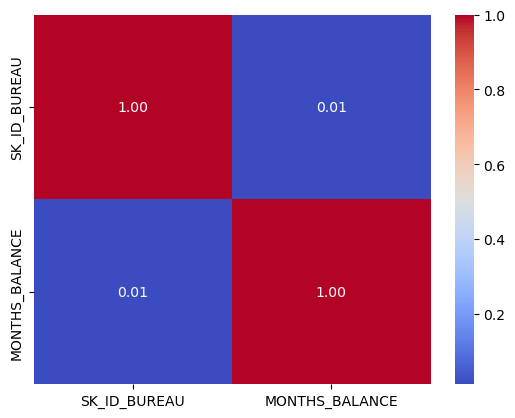

In [12]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [13]:
max_corr = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
min_corr = correlation_matrix.unstack().sort_values().drop_duplicates()
print("Các cặp features có correlation cao nhất:\n", max_corr.head())
print("\nCác cặp features có correlation thấp nhất:\n", min_corr.head())

Các cặp features có correlation cao nhất:
 SK_ID_BUREAU  SK_ID_BUREAU      1.000000
              MONTHS_BALANCE    0.011873
dtype: float64

Các cặp features có correlation thấp nhất:
 SK_ID_BUREAU  MONTHS_BALANCE    0.011873
              SK_ID_BUREAU      1.000000
dtype: float64


In [14]:
df2 = pd.read_csv("D:\data prep\dseb63_final_project_DP_dataset\dseb63_final_project_DP_dataset\dseb63_application_train.csv")
df2 = df2[['SK_ID_CURR','TARGET']]

In [15]:
merge_table = pd.merge(df, df2, on='SK_ID_CURR', how='left')
merge_table

KeyError: 'SK_ID_CURR'